# From Neurons to Networks: Exploring Deep Learning Algorithms

Roderick Perez, Ph.D.
OMV

---

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

1. Download the Solar Sunspot Dataset

In [18]:
# Download dataset (monthly sunspot data)
filePath = 'sunspot_data.csv'
data = pd.read_csv(filePath)

In [19]:
# Display the first few rows
data.head()

,Unnamed: 0,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
0,0,1818,1,1,1818.001,-1,-1.0,0,1
1,1,1818,1,2,1818.004,-1,-1.0,0,1
2,2,1818,1,3,1818.007,-1,-1.0,0,1
3,3,1818,1,4,1818.010,-1,-1.0,0,1
4,4,1818,1,5,1818.012,-1,-1.0,0,1


In [20]:
# Filter and preprocess the dataset to focus on "Number of Sunspots"
data = data[data['Number of Sunspots'] >= 0]  # Remove negative values or missing entries
sunspots = data['Number of Sunspots'].values.reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
sunspots_normalized = scaler.fit_transform(sunspots)

In [21]:
print(f"Filtered data shape: {filtered_data.shape}")
print(f"Sunspots shape: {sunspots.shape}")

Filtered data shape: (70471, 9)
Sunspots shape: (70471, 1)


2. Plot the Dataset Using Matplotlib

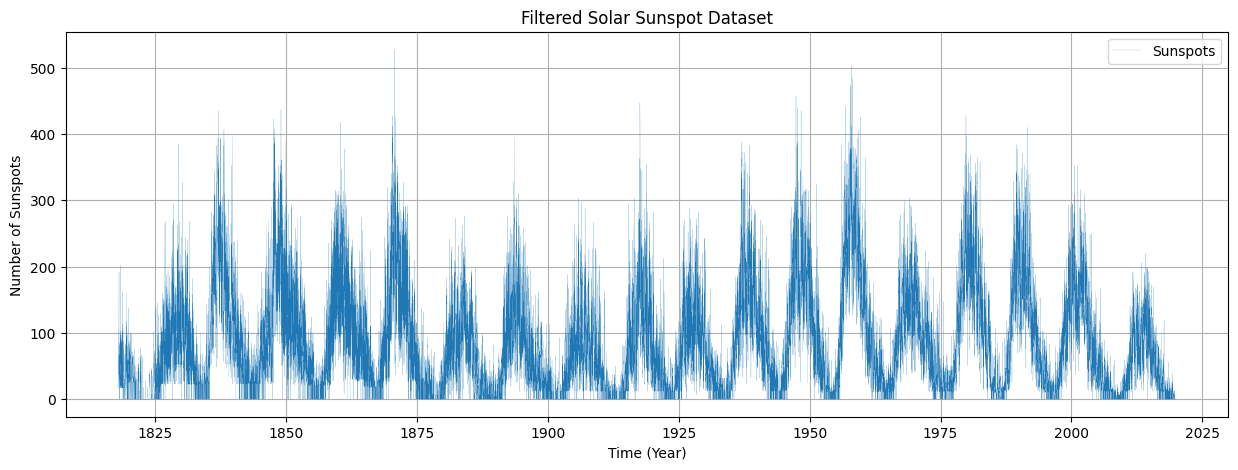

In [22]:
# Plot the dataset
plt.figure(figsize=(15, 5))
plt.plot(filtered_data['Date In Fraction Of Year'], sunspots, label='Sunspots', linewidth = 0.1)
plt.title('Filtered Solar Sunspot Dataset')
plt.xlabel('Time (Year)')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.grid(True)
plt.show()

---

In [23]:
!pip install torch

In [24]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [25]:
# Create windowed dataset
def create_windowed_dataset(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [26]:
window_size = 12  # You can experiment with this value
X, y = create_windowed_dataset(sunspots_normalized, window_size)

In [27]:
# Convert the data to PyTorch tensors
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

In [28]:
# Define the LSTM Model in PyTorch
class SunspotLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(SunspotLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [29]:
# Hyperparameters
learning_rate = 0.001
epochs = 100  # You can increase this value for better training
input_size = 1
hidden_layer_size = 50
output_size = 1

In [30]:
# Initialize the model, loss function, and optimizer
model = SunspotLSTM(input_size=input_size, hidden_layer_size=hidden_layer_size, output_size=output_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
# Training loop
losses = []
for epoch in range(epochs):
    for seq, labels in zip(X, y):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    losses.append(single_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {single_loss.item()}')

Epoch 0, Loss: 4.550521737201052e-09
Epoch 10, Loss: 4.915406748295936e-09
Epoch 20, Loss: 3.01028624249966e-09
Epoch 30, Loss: 2.3975923468810834e-09
Epoch 40, Loss: 9.072223861039674e-09
Epoch 50, Loss: 4.53646009646036e-09
Epoch 60, Loss: 2.798317133567707e-09
Epoch 70, Loss: 5.802590408165997e-09
Epoch 80, Loss: 8.04163935441693e-09
Epoch 90, Loss: 3.2844207353832644e-09


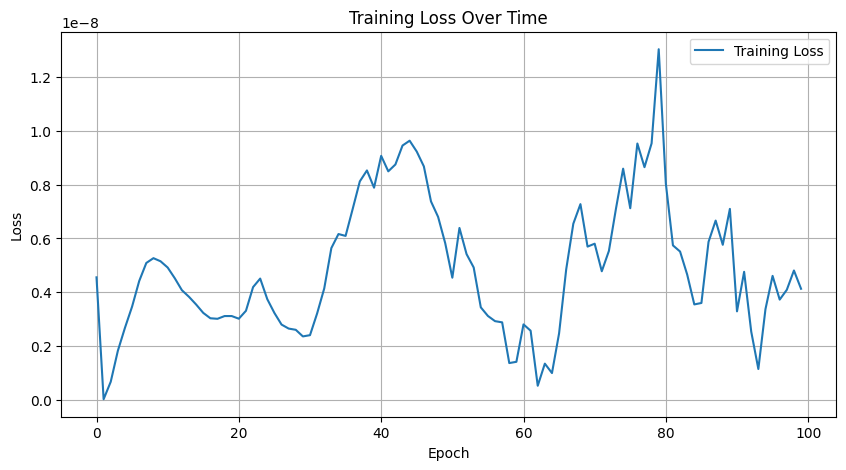

In [32]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Generating predictions for the dataset
model.eval()
predictions = []
for seq in X:
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        predictions.append(model(seq).item())

In [34]:
# Inverse transform the normalized values back to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

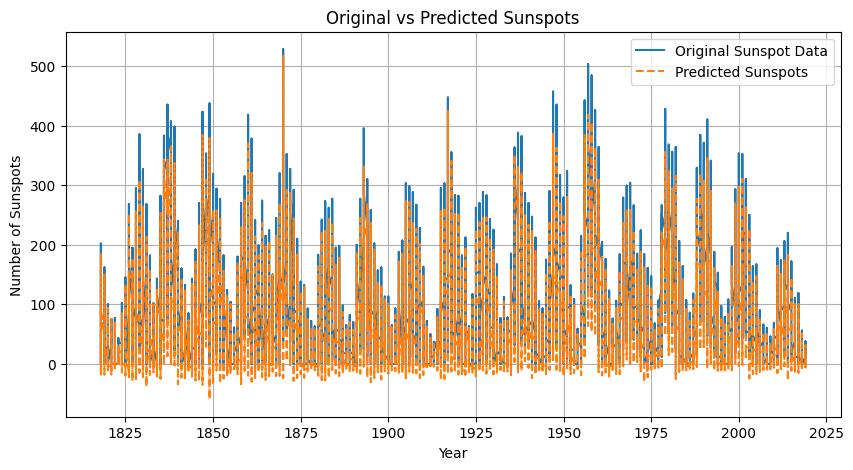

In [35]:
# Plot original data vs predictions
plt.figure(figsize=(10, 5))
plt.plot(data['Year'], sunspots, label='Original Sunspot Data')
plt.plot(data['Year'][window_size:], predictions, label='Predicted Sunspots', linestyle='dashed')
plt.xlabel('Year')
plt.ylabel('Number of Sunspots')
plt.title('Original vs Predicted Sunspots')
plt.legend()
plt.grid(True)
plt.show()